# Subscriber vs Non-Subscriber Usage Patterns (2018)

Goal: explore whether subscribers and non-subscribers use the service differently. Notebook is self-contained; installs and imports are at the top.

## Setup
Install dependencies. If you already have them, skip this step.

In [1]:
%pip install pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["figure.figsize"] = (10, 5)

## Load trips + weather
- Adds basic time/age features.
- Merges hourly weather to trip start hour (extension requested in project guidelines).

In [3]:
# Weather
weather = pd.read_csv("../data/weather_2018.csv")
weather["weather_time"] = pd.to_datetime(weather["datetime"])
weather_features = ["temp", "humidity", "precip", "windspeed"]
weather = weather[["weather_time"] + weather_features]
weather.head()

,weather_time,temp,humidity,precip,windspeed
0,2018-01-01 00:00:00,-12.5,57.65,0.0,20.5
1,2018-01-01 01:00:00,-12.5,57.65,0.0,23.1
2,2018-01-01 02:00:00,-12.6,58.09,0.0,22.4
3,2018-01-01 03:00:00,-13.1,59.72,0.0,18.4
4,2018-01-01 04:00:00,-13.1,57.39,0.0,18.5


In [4]:
trips = pd.read_csv("../data/processed_trips_2018.csv")

# Parse times
trips["starttime"] = pd.to_datetime(trips["starttime"])
trips["stoptime"] = pd.to_datetime(trips["stoptime"])

# Time related features
trips["duration_min"] = trips["tripduration"] / 60
trips["start_hour"] = trips["starttime"].dt.floor("h")

trips["hour"] = trips["starttime"].dt.hour
trips["dayofweek"] = trips["starttime"].dt.day_name()
trips["month"] = trips["starttime"].dt.month
trips["is_weekend"] = trips["starttime"].dt.dayofweek >= 5

# Age (birth_year can be missing or non-numeric)
trips["birth_year"] = pd.to_numeric(trips["birth_year"], errors="coerce")
trips["age"] = 2018 - trips["birth_year"]

trips.head()


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,pickup_day,dropoff_hour,dropoff_day,duration_min,start_hour,hour,dayofweek,month,is_weekend,age
0,196,2018-01-01 00:01:50.650,2018-01-01 00:05:07.438,315.0,40.703554,-74.006702,259.0,40.701221,-74.012342,18534,...,2018-01-01,0,2018-01-01,3.266667,2018-01-01,0,Monday,1,False,21
1,207,2018-01-01 00:02:43.918,2018-01-01 00:06:11.383,3224.0,40.739974,-74.005139,470.0,40.743453,-74.000040,19651,...,2018-01-01,0,2018-01-01,3.450000,2018-01-01,0,Monday,1,False,40
2,613,2018-01-01 00:03:15.116,2018-01-01 00:13:28.480,386.0,40.714948,-74.002345,2008.0,40.705693,-74.016777,21678,...,2018-01-01,0,2018-01-01,10.216667,2018-01-01,0,Monday,1,False,36
3,375,2018-01-01 00:06:43.709,2018-01-01 00:12:59.450,466.0,40.743954,-73.991449,325.0,40.736245,-73.984738,29822,...,2018-01-01,0,2018-01-01,6.250000,2018-01-01,0,Monday,1,False,36
4,402,2018-01-01 00:06:56.924,2018-01-01 00:13:39.792,438.0,40.727791,-73.985649,380.0,40.734011,-74.002939,30722,...,2018-01-01,0,2018-01-01,6.700000,2018-01-01,0,Monday,1,False,29


In [5]:
trips = trips.merge(weather, left_on="start_hour", right_on="weather_time", how="left")

print("Trips rows:", len(trips))

Trips rows: 17545760


## Quick descriptive comparison
High-level differences between subscribers and customers before plotting.

- Trip counts and ride duration (mean/median)
- Age profile (trim obvious outliers)
- Gender split and weekend vs weekday mix

In [6]:
# Trip counts and ride length by user type
duration_summary = trips.groupby("usertype")["duration_min"].agg(trips="count", mean_min="mean", median_min="median")

duration_summary

,trips,mean_min,median_min
usertype,,,
Customer,1932463,42.968582,21.366667
Subscriber,15613297,13.192905,9.283333


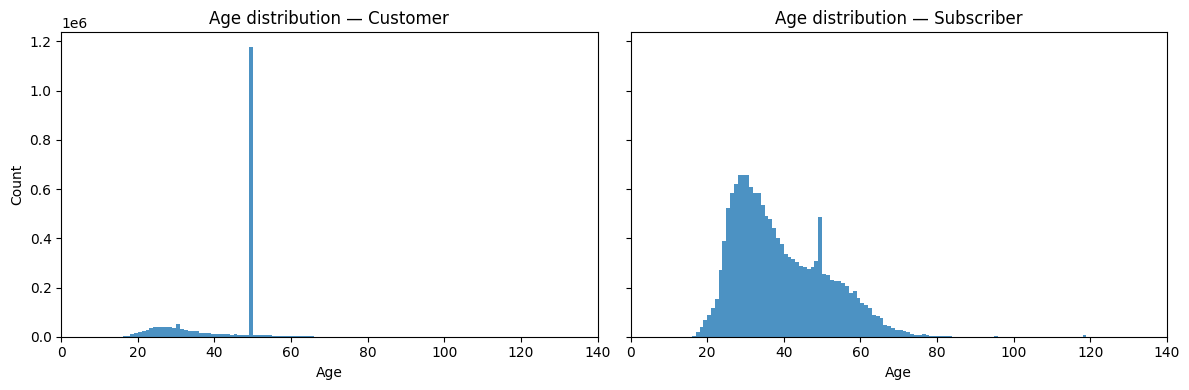

In [7]:
# Age, gender, and weekend mix
age_summary = (
    trips.groupby("usertype")["age"]
    .agg(
        median_age="median",
        mean_age="mean"
    ).round(1)
)
# diagnostics
age_diagnostic = (
    trips.groupby("usertype")["age"].agg(
        count="count",
        missing=lambda s: s.isna().sum(),
        min_age="min",
        q10=lambda s: s.quantile(0.1),
        median_age="median",
        mean_age="mean",
        max_age="max"
    ).round(1)
)

# Plot age histogram for Customer and Subscriber (matplotlib only)
bins = range(0, 141, 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

for ax, user in zip(axes, ["Customer", "Subscriber"]):
    ages = trips.loc[trips["usertype"] == user, "age"].dropna()
    ax.hist(ages, bins=bins, alpha=0.8)
    ax.set_title(f"Age distribution — {user}")
    ax.set_xlim(0, 140)
    ax.set_xlabel("Age")

axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()


In [8]:
gender_map = {0: "Unknown", 1: "Male", 2: "Female"}
gender_share = (
    trips.assign(gender_label=trips["gender"].map(gender_map).fillna("Unknown"))
    .groupby(["usertype", "gender_label"])
    .size()
    .groupby(level=0)
    .apply(lambda s: s / s.sum())
    .unstack(fill_value=0)
    .round(3)
    .sort_index(axis=1)
)


weekend_mix = (
    trips.groupby(["usertype", "is_weekend"])
    .size()
    .groupby(level=0)
    .apply(lambda s: s / s.sum())
    .unstack()
    .rename(columns={False: "weekday_share", True: "weekend_share"})
    .fillna(0)
    .round(3)
)

display(gender_share)
display(weekend_mix)

,gender_label,Female,Male,Unknown
usertype,usertype,,,
Customer,Customer,0.145,0.245,0.61
Subscriber,Subscriber,0.244,0.736,0.02


,is_weekend,weekday_share,weekend_share
usertype,usertype,,
Customer,Customer,0.557,0.443
Subscriber,Subscriber,0.784,0.216


## Exploratory visualizations
Focus on subscriber vs non-subscriber usage patterns.

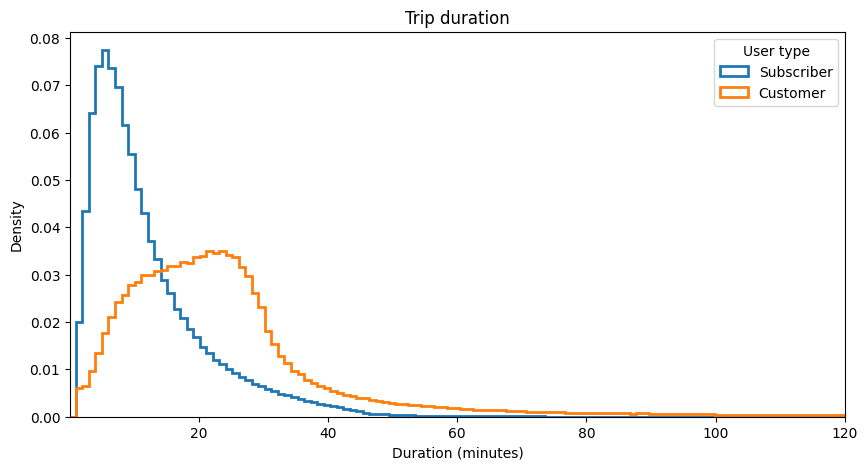

In [9]:
# Trip duration histogram (density) by user type
bins = np.linspace(0,120, 120)
for user in trips["usertype"].unique():
    durations = trips.loc[trips["usertype"] == user, "duration_min"]
    plt.hist(durations, bins=bins, density=True, histtype="step", linewidth=2, label=user)

plt.xlim(0.1, 120)
plt.title("Trip duration")
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.legend(title="User type")
plt.show()


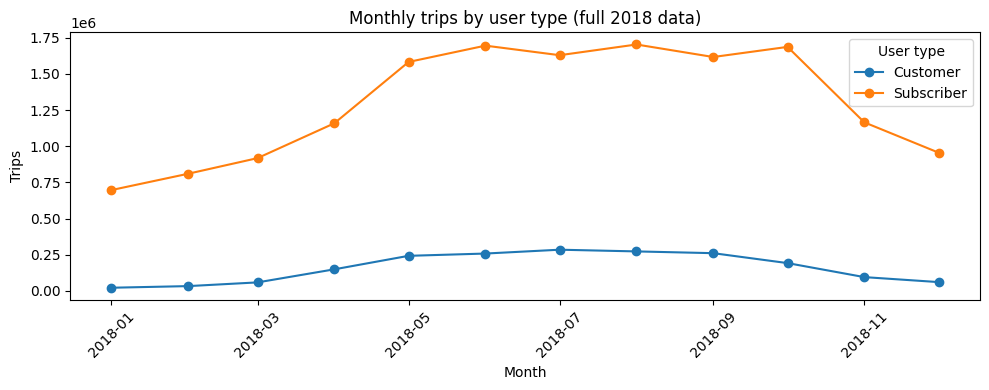

In [10]:
# Subscribers vs customers over time (monthly, full dataset)
monthly_counts = (
    trips.assign(month_start=trips["starttime"].dt.to_period("M").dt.to_timestamp())
    .groupby(["month_start", "usertype"])
    .size()
    .reset_index(name="trips")
    .sort_values("month_start")
)

plt.figure(figsize=(10, 4))
for user, group in monthly_counts.groupby("usertype"):
    plt.plot(group["month_start"], group["trips"], marker="o", label=user)

plt.title("Monthly trips by user type (full 2018 data)")
plt.xlabel("Month")
plt.ylabel("Trips")
plt.xticks(rotation=45)
plt.legend(title="User type")
plt.tight_layout()
plt.show()

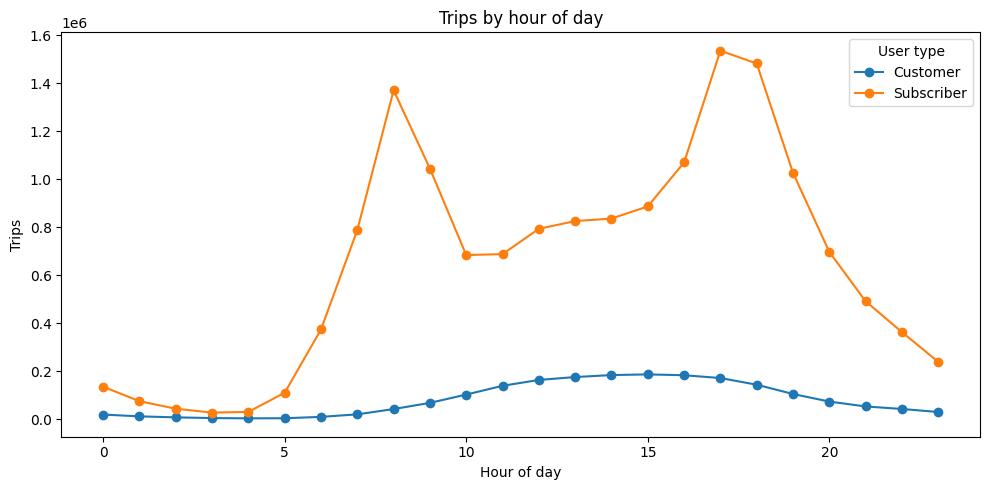

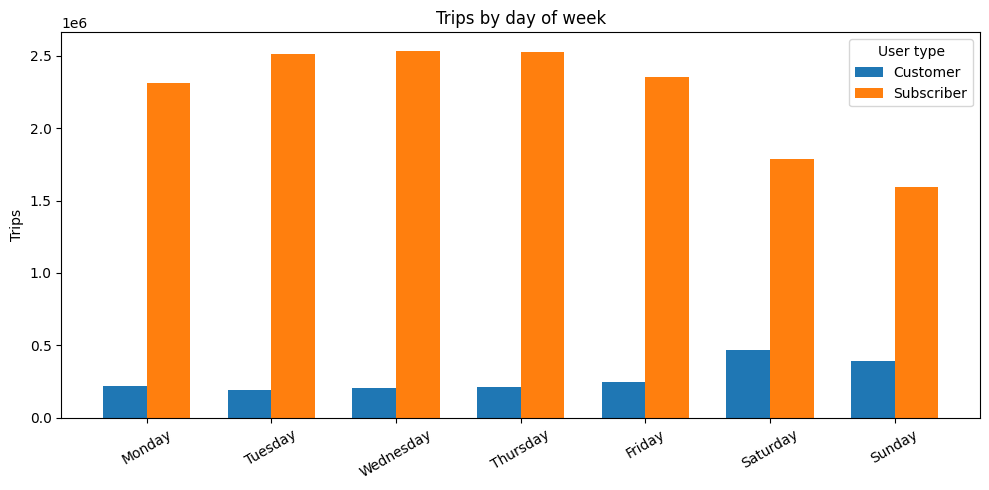

In [11]:
# Hour-of-day pattern
hourly = trips.groupby(["hour", "usertype"]).size().reset_index(name="trips")

plt.figure(figsize=(10, 5))
for user, group in hourly.groupby("usertype"):
    plt.plot(group["hour"], group["trips"], marker="o", label=user)
plt.title("Trips by hour of day")
plt.xlabel("Hour of day")
plt.ylabel("Trips")
plt.legend(title="User type")
plt.tight_layout()
plt.show()

# Day-of-week pattern
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot = (
    trips.groupby(["dayofweek", "usertype"]).size().unstack(fill_value=0)
    .reindex(order)
)

x = np.arange(len(order))
width = 0.35
for i, user in enumerate(pivot.columns):
    plt.bar(x + i * width - width / 2, pivot[user], width, label=user)

plt.xticks(x, order, rotation=30)
plt.ylabel("Trips")
plt.title("Trips by day of week")
plt.legend(title="User type")
plt.tight_layout()
plt.show()


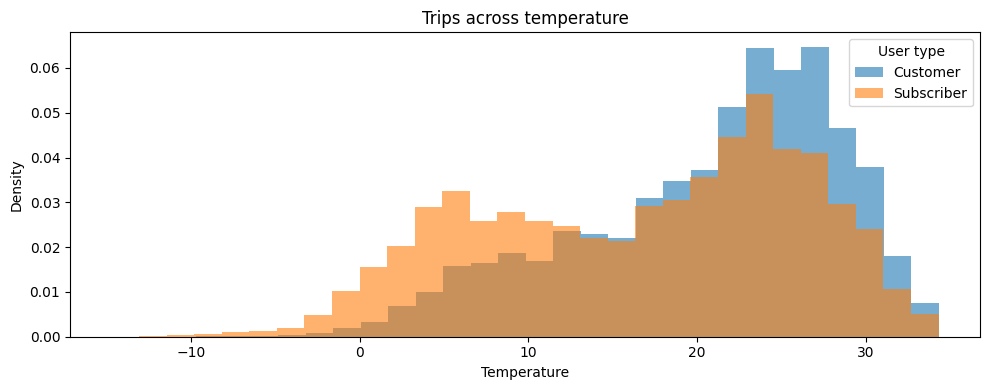

In [12]:
# Weather sensitivity: trips vs temperature

plt.figure(figsize=(10, 4))
for user, group in trips.groupby("usertype"):
    temps = group["temp"].dropna()
    plt.hist(temps, bins=30, density=True, alpha=0.6, label=user)

plt.title("Trips across temperature")
plt.xlabel("Temperature")
plt.ylabel("Density")
plt.legend(title="User type")
plt.tight_layout()
plt.show()


## Supervised learning: predict subscriber vs non-subscriber
We will now train and test two models: Logistic Regression (linear baseline) and Random Forest (non-linear, handles interactions). Features include duration, time-of-day, location, and weather.

The full dataset has more than 17 million datapoints which will take very long to train on a cpu. It could be advantageous to utilize the fact that Random Forest can be trained and run in parallel as each tree can be trained on its own node. Unfortunately, however, sklearn does not support cuda or MPS implementation. We could use torch instead of sklearn and/or use DTU's hpc to train the model, but we choose to stick with methods we have used in class, therefore we will now take a subset of the data.

In [13]:
n_sample = 100000 # Number of samples to include for the supervised learning section
trips_sample = trips.sample(n=n_sample)

In [14]:
# Prepare labeled data for binary classification (no age or gender: high customer missingness)
feature_cols = [
    "duration_min",
    "hour",
    "start_station_latitude",
    "start_station_longitude",
    "temp",
    "humidity",
    "precip",
    "windspeed",
]

# Keep rows with all selected features, create target 1=customer, 0=subscriber
model_data = trips_sample[feature_cols + ["usertype"]].dropna().copy()
model_data["is_subscriber"] = (model_data["usertype"] == "Customer").astype(int)

# Train/test split (simple 80/20 split for logistic regression)
split = int(len(model_data) * 0.8)
train = model_data.iloc[:split]
test = model_data.iloc[split:]

X_train = train[feature_cols]
X_test = test[feature_cols]
y_train = train["is_subscriber"]
y_test = test["is_subscriber"]

Logistic Regression (train set)
Accuracy: 0.891
F1:       0.057
ROC-AUC:  0.742
PR-AUC:   0.294

Logistic Regression (test set)
Accuracy: 0.892
F1:       0.054
ROC-AUC:  0.746
PR-AUC:   0.295


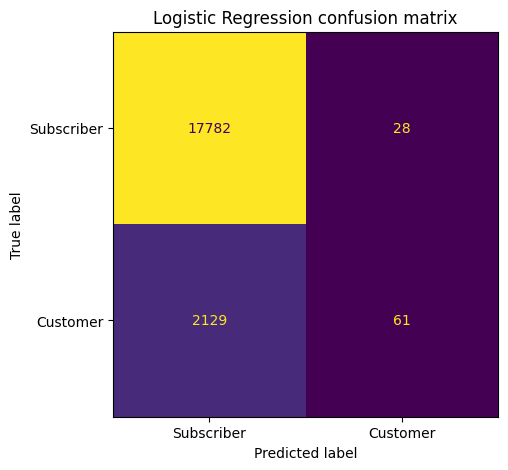

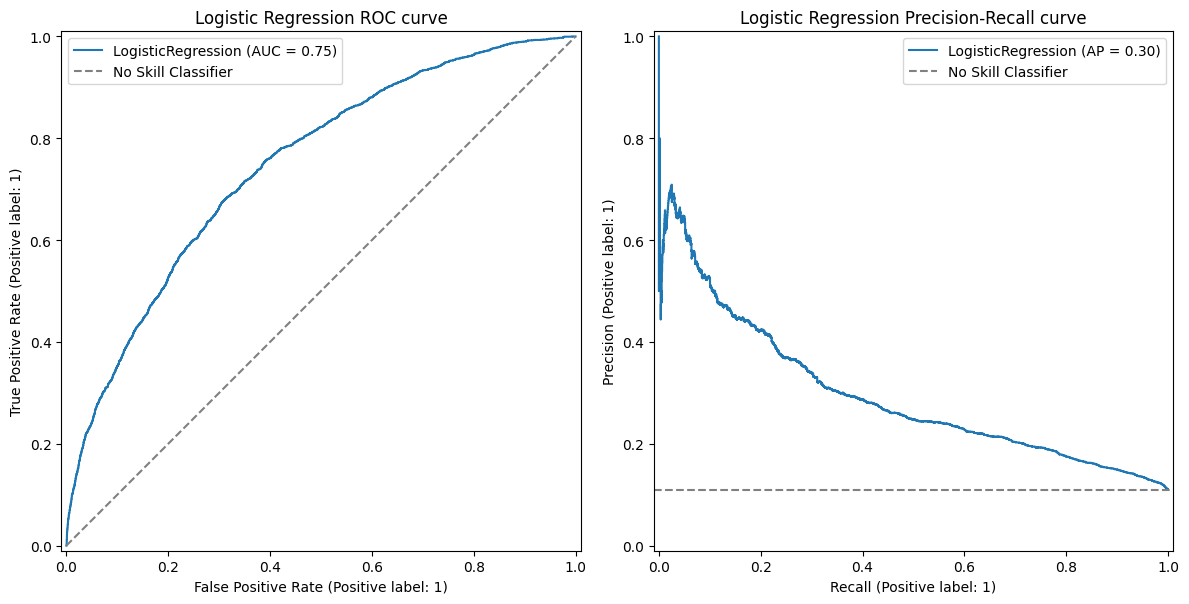

In [15]:
# Logistic Regression baseline (linear decision boundary)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Train set predictions
train_pred = log_reg.predict(X_train)
train_proba = log_reg.predict_proba(X_train)[:, 1]

# Test set predictions
test_pred = log_reg.predict(X_test)
test_proba = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression (train set)")
print("Accuracy:", round(accuracy_score(y_train, train_pred), 3))
print("F1:      ", round(f1_score(y_train, train_pred), 3))
print("ROC-AUC: ", round(roc_auc_score(y_train, train_proba), 3))
print("PR-AUC:  ", round(average_precision_score(y_train, train_proba), 3))

print("\nLogistic Regression (test set)")
print("Accuracy:", round(accuracy_score(y_test, test_pred), 3))
print("F1:      ", round(f1_score(y_test, test_pred), 3))
print("ROC-AUC: ", round(roc_auc_score(y_test, test_proba), 3))
print("PR-AUC:  ", round(average_precision_score(y_test, test_proba), 3))

ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred), display_labels=["Subscriber", "Customer"]).plot(colorbar=False)
plt.title("Logistic Regression confusion matrix")
plt.show()

# ROC and PR curves side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ROC curve
RocCurveDisplay.from_estimator(log_reg, X_test, y_test, ax=axes[0])
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='No Skill Classifier')
axes[0].set_title("Logistic Regression ROC curve")
axes[0].legend()

# Precision-Recall curve
no_skill = y_test.mean()
PrecisionRecallDisplay.from_estimator(log_reg, X_test, y_test, ax=axes[1])
axes[1].axhline(y=no_skill, linestyle='--', color='gray', label='No Skill Classifier')
axes[1].set_title("Logistic Regression Precision-Recall curve")
axes[1].legend()

plt.tight_layout()
plt.show()

In [16]:
# Train/validation/test split (60/20/20) for Random Forest. Same test set as before
n = len(model_data)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train = model_data.iloc[:train_end]
val = model_data.iloc[train_end:val_end]
test = model_data.iloc[val_end:]

X_train = train[feature_cols]
X_val = val[feature_cols]
X_test = test[feature_cols]
y_train = train["is_subscriber"]
y_val = val["is_subscriber"]
y_test = test["is_subscriber"]

# Define parameter grid to search
n_estimators = [50, 100, 200]
max_depth = [5, 10, 20, None]
min_samples_split = [2, 5, 10]

# Store results
results = []

for n_est in n_estimators:
    for max_d in max_depth:
        for min_split in min_samples_split:
            rf = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=max_d,
                min_samples_split=min_split,
                random_state=42,
                n_jobs=-1
            )
            rf.fit(X_train, y_train)
            
            # Evaluate on validation set
            val_proba = rf.predict_proba(X_val)[:, 1]
            val_pred = rf.predict(X_val)
            val_auc = roc_auc_score(y_val, val_proba)
            val_f1 = f1_score(y_val, val_pred)
            
            results.append({
                'n_estimators': n_est,
                'max_depth': max_d,
                'min_samples_split': min_split,
                'val_roc_auc': val_auc,
                'val_f1': val_f1
            })

# Convert to DataFrame and find best parameters
results_df = pd.DataFrame(results).sort_values('val_roc_auc', ascending=False)
print(results_df.head(10).to_string(index=False))

# Get best parameters
best_params = results_df.iloc[0]
print(f"Best parameters:")
print(f"n_estimators: {best_params['n_estimators']}")
print(f"max_depth: {best_params['max_depth']}")
print(f"min_samples_split: {best_params['min_samples_split']}")
print(f"Validation ROC-AUC: {best_params['val_roc_auc']:.4f}")

 n_estimators  max_depth  min_samples_split  val_roc_auc   val_f1
          200       10.0                 10     0.820922 0.203089
          100       10.0                  5     0.820830 0.196170
          200       10.0                  2     0.820632 0.199690
          200       10.0                  5     0.820478 0.197742
          100       10.0                 10     0.820298 0.201550
          100       10.0                  2     0.819958 0.203861
           50       10.0                 10     0.819910 0.193901
           50       10.0                  2     0.819044 0.200620
           50       10.0                  5     0.819042 0.196964
          200       20.0                 10     0.817616 0.257807
Best parameters:
n_estimators: 200.0
max_depth: 10.0
min_samples_split: 10.0
Validation ROC-AUC: 0.8209


Notice: The best parameters might change from run to run because we didn't use a specific random set when sampling from the dataset

Random Forest (train set)
Accuracy: 0.902
F1:       0.233
ROC-AUC:  0.884
PR-AUC:   0.545

Random Forest (test set)
Accuracy: 0.897
F1:       0.191
ROC-AUC:  0.825
PR-AUC:   0.43


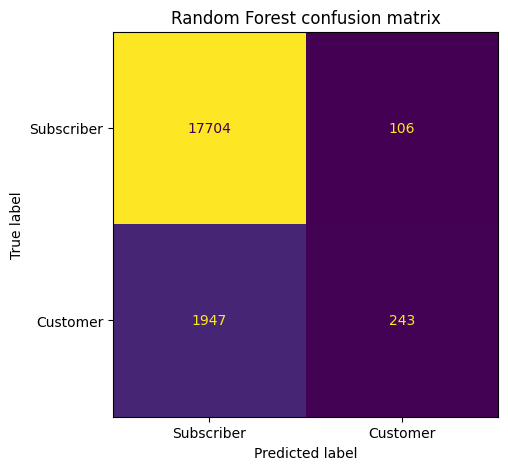

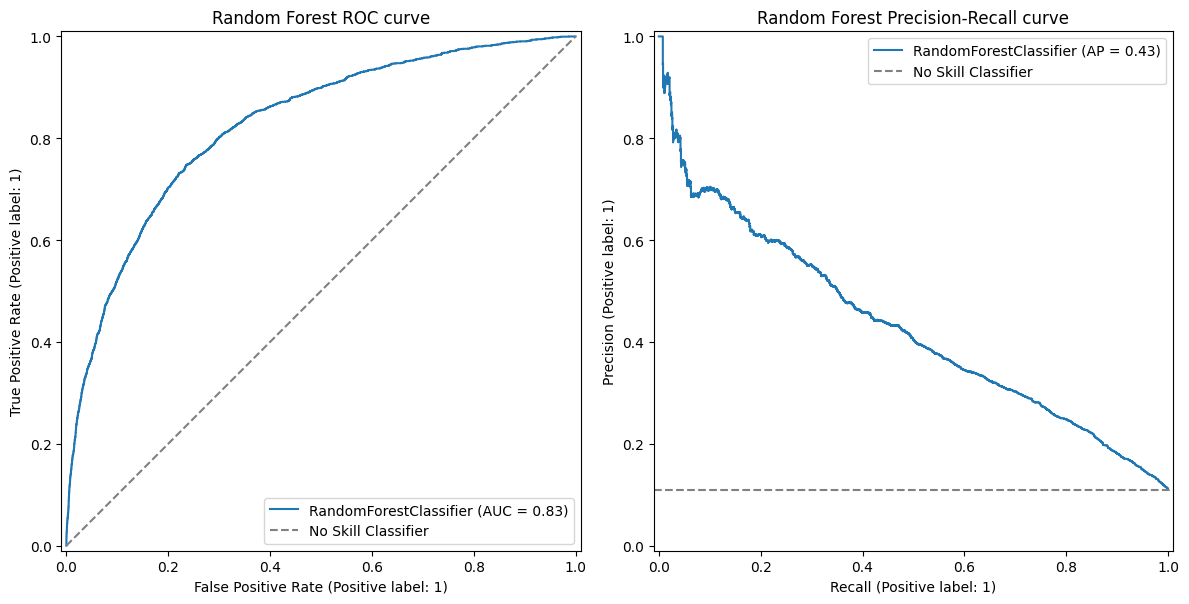

In [ ]:
# Random Forest captures nonlinearities and interactions
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    min_samples_split=5,
    n_jobs=-1 # -1 is using all processors
)
rf_clf.fit(X_train, y_train)

# Train set predictions
rf_train_pred = rf_clf.predict(X_train)
rf_train_proba = rf_clf.predict_proba(X_train)[:, 1]

# Test set predictions
rf_test_pred = rf_clf.predict(X_test)
rf_test_proba = rf_clf.predict_proba(X_test)[:, 1]

print("Random Forest (train set)")
print("Accuracy:", round(accuracy_score(y_train, rf_train_pred), 3))
print("F1:      ", round(f1_score(y_train, rf_train_pred), 3))
print("ROC-AUC: ", round(roc_auc_score(y_train, rf_train_proba), 3))
print("PR-AUC:  ", round(average_precision_score(y_train, rf_train_proba), 3))

print("\nRandom Forest (test set)")
print("Accuracy:", round(accuracy_score(y_test, rf_test_pred), 3))
print("F1:      ", round(f1_score(y_test, rf_test_pred), 3))
print("ROC-AUC: ", round(roc_auc_score(y_test, rf_test_proba), 3))
print("PR-AUC:  ", round(average_precision_score(y_test, rf_test_proba), 3))

ConfusionMatrixDisplay(confusion_matrix(y_test, rf_test_pred), display_labels=["Subscriber", "Customer"]).plot(colorbar=False)
plt.title("Random Forest confusion matrix")
plt.show()

# ROC and PR curves side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ROC curve
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=axes[0])
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='No Skill Classifier')
axes[0].set_title("Random Forest ROC curve")
axes[0].legend()

# Precision-Recall curve
no_skill = y_test.mean()
PrecisionRecallDisplay.from_estimator(rf_clf, X_test, y_test, ax=axes[1])
axes[1].axhline(y=no_skill, linestyle='--', color='gray', label='No Skill Classifier')
axes[1].set_title("Random Forest Precision-Recall curve")
axes[1].legend()

plt.tight_layout()
plt.show()